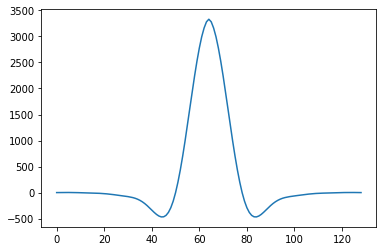

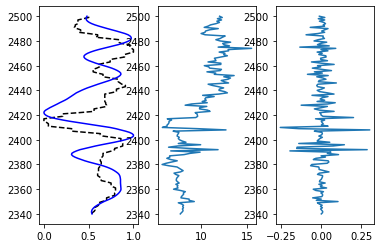

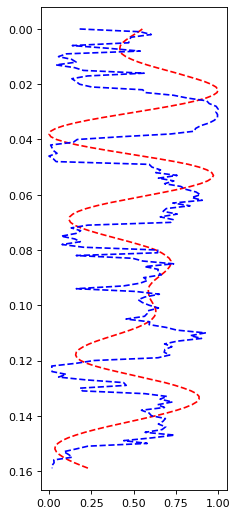

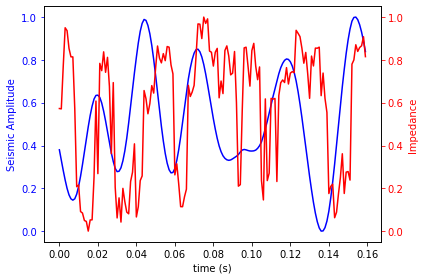

In [1]:
%run ./01v_volve_generate_data.ipynb

import tensorflow as tf
import keras
from keras import layers
from keras import backend as K
#import src

import scipy.stats as stats
import math

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# expected input data shape: (batch_size, timesteps, data_dim)
max_epochs = 1000
num_responses = 1
mini_batch_size = 5
num_features = 1

num_first_hidden_unit = 75
num_second_hidden_unit = 25

lstm_net = keras.models.Sequential()
lstm_net.add(layers.InputLayer(input_shape=(160, num_responses))) # (timesteps, data_dim)
lstm_net.add(layers.LSTM(num_first_hidden_unit,
                         batch_input_shape=(5, 160, num_responses),
                         return_sequences=True))
lstm_net.add(layers.Dropout(0.2))
lstm_net.add(layers.LSTM(num_second_hidden_unit,
                         return_sequences=True))
lstm_net.add(layers.Dropout(0.2))
lstm_net.add(layers.Dense(10))
lstm_net.add(layers.Dense(num_responses))

lstm_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 160, 75)           23100     
_________________________________________________________________
dropout (Dropout)            (None, 160, 75)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 160, 25)           10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 160, 25)           0         
_________________________________________________________________
dense (Dense)                (None, 160, 10)           260       
_________________________________________________________________
dense_1 (Dense)              (None, 160, 1)            11        
Total params: 33,471
Trainable params: 33,471
Non-trainable params: 0
____________________________________________________

In [4]:
def scheduler(epoch, lr):
    if epoch % 150 == 0 and epoch != 0:
        value = lr * tf.math.exp(-0.1)
        K.set_value(lstm_net.optimizer.lr, value)
        return K.get_value(lstm_net.optimizer.lr)
    else:
        return K.get_value(lstm_net.optimizer.lr)
    
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=2)

metric = 'mse'

lstm_net.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=metric)

history_lstm = lstm_net.fit(trainX,
                            trainIp,
                            shuffle=False,
                            batch_size=mini_batch_size,
                            epochs=max_epochs,
#                            callbacks=[lr_scheduler],
                            validation_data=(x_valid, y_valid),
                            validation_freq=1)

Epoch 1/1000
150/150 [==============================] - 6s 22ms/step - loss: 0.1061 - mse: 0.1061 - val_loss: 0.0639 - val_mse: 0.0639
Epoch 2/1000
150/150 [==============================] - 2s 14ms/step - loss: 0.0640 - mse: 0.0640 - val_loss: 0.0582 - val_mse: 0.0582
Epoch 3/1000
150/150 [==============================] - 2s 14ms/step - loss: 0.0575 - mse: 0.0575 - val_loss: 0.0512 - val_mse: 0.0512
Epoch 4/1000
150/150 [==============================] - 2s 14ms/step - loss: 0.0498 - mse: 0.0498 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 5/1000
150/150 [==============================] - 2s 14ms/step - loss: 0.0467 - mse: 0.0467 - val_loss: 0.0471 - val_mse: 0.0471
Epoch 6/1000
150/150 [==============================] - 2s 15ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0459 - val_mse: 0.0459
Epoch 7/1000
150/150 [==============================] - 2s 15ms/step - loss: 0.0441 - mse: 0.0441 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 8/1000
150/150 [==============================] -

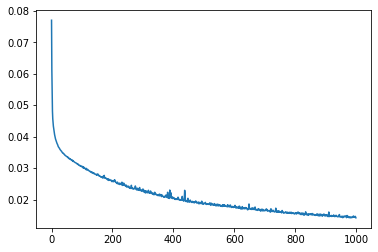

In [5]:
plt.plot(history_lstm.history[metric])
plt.show()

9/9 [==============================] - 1s 7ms/step


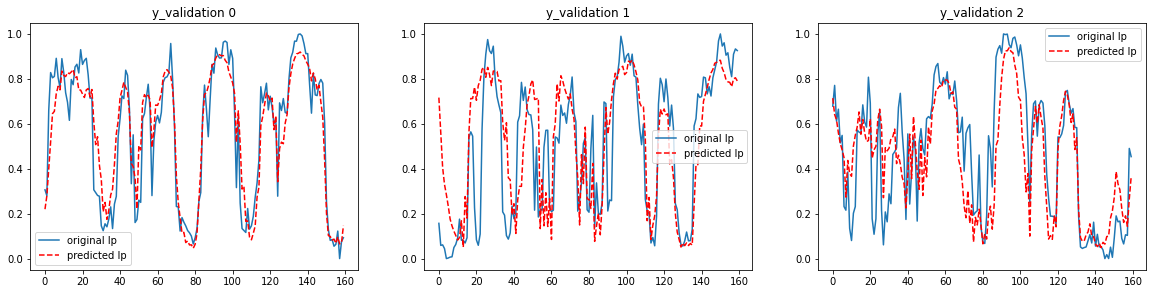

In [6]:
y_predicted = lstm_net.predict(x_test, verbose=1)
# print(np.shape(y_predicted))

n = 3
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("y_validation {0}".format(i-1))
    plt.plot(y_test[i-1, :, 0])
    plt.plot(y_predicted[i-1, :, 0], '--r')
    plt.legend(['original Ip', 'predicted Ip'])

#     ax = plt.subplot(2, n, i + n, sharey=ax)
#     ax.set_title("y_predicted {0}".format(i-1))
#     plt.plot(y_predicted[i-1, :, 0])
plt.show()